In [55]:
from scipy.spatial import distance
from scipy.stats import pearsonr
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
import pandas as pd
import numpy as np
import xgboost
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import cross_validation, tree, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from datetime import timedelta

In [ ]:
pd.options.display.float_format = '{:.1f}'.format
train_df = pd.read_csv('data/train.csv')
train_df.describe()

In [2]:
def clean_data(train_df):
    cleaned_df = train_df[train_df.passenger_count.between(0,11) &
                          (train_df.pickup_latitude.between(40.5,41)) &
                          (train_df.dropoff_latitude.between(40.5,41)) &
                          (train_df.pickup_longitude.between(-74.5,-73.8)) &
                          (train_df.dropoff_longitude.between(-74.5,-73.8))&
                          (train_df.fare_amount.between(1,1000))]
    return cleaned_df

In [3]:
import pandas as pd
train_df = pd.read_csv('data/train.csv', chunksize=1000000)
df_list = []
cnt = 0
for chunk in train_df:
    tmp_df = clean_data(chunk)
    df_list.append(tmp_df)
clean_df = pd.concat(df_list)


In [4]:
clean_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5.297403e+07,5.297403e+07,5.297403e+07,5.297403e+07,5.297403e+07,5.297403e+07
mean,1.052187e+01,-7.397857e+01,4.075248e+01,-7.397676e+01,4.075229e+01,1.683716e+00
std,7.810273e+00,2.507221e-02,2.374398e-02,2.793270e-02,2.904663e-02,1.307968e+00
min,1.000000e+00,-7.450000e+01,4.050000e+01,-7.450000e+01,4.050000e+01,0.000000e+00
25%,6.000000e+00,-7.399248e+01,4.073757e+01,-7.399173e+01,4.073659e+01,1.000000e+00
50%,8.100000e+00,-7.398230e+01,4.075394e+01,-7.398088e+01,4.075425e+01,1.000000e+00
75%,1.210000e+01,-7.396934e+01,4.076784e+01,-7.396635e+01,4.076856e+01,2.000000e+00
max,9.000000e+02,-7.380000e+01,4.100000e+01,-7.380000e+01,4.100000e+01,9.000000e+00


In [5]:
clean_df.dropna()
clean_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5.297403e+07,5.297403e+07,5.297403e+07,5.297403e+07,5.297403e+07,5.297403e+07
mean,1.052187e+01,-7.397857e+01,4.075248e+01,-7.397676e+01,4.075229e+01,1.683716e+00
std,7.810273e+00,2.507221e-02,2.374398e-02,2.793270e-02,2.904663e-02,1.307968e+00
min,1.000000e+00,-7.450000e+01,4.050000e+01,-7.450000e+01,4.050000e+01,0.000000e+00
25%,6.000000e+00,-7.399248e+01,4.073757e+01,-7.399173e+01,4.073659e+01,1.000000e+00
50%,8.100000e+00,-7.398230e+01,4.075394e+01,-7.398088e+01,4.075425e+01,1.000000e+00
75%,1.210000e+01,-7.396934e+01,4.076784e+01,-7.396635e+01,4.076856e+01,2.000000e+00
max,9.000000e+02,-7.380000e+01,4.100000e+01,-7.380000e+01,4.100000e+01,9.000000e+00


In [6]:
#append these features to the cleaned_train.csv
# This serves as a checkpoint to the work done so far.
clean_df.to_csv('data/clean_train.csv', mode='w')

In [17]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 3956 # Radius of earth in 6371 kilometers. Use 3956 for miles
    return c * r

In [18]:
import numpy
def eucledian_dist(lat1,long1, lat2, long2):
    x = numpy.array((lat1, long1))
    y = numpy.array((lat2, long2))
    dist = numpy.linalg.norm(x-y)
    return dist

In [19]:
from datetime import datetime
def get_hour(time_in_utc):
    time_obj = datetime.strptime(time_in_utc,'%Y-%m-%d %H:%M:%S UTC').time()
    return time_obj.hour

In [ ]:
clean_df["eucledian_dist"] = clean_df.apply(lambda row: eucledian_dist(row["pickup_latitude"], row["pickup_longitude"], row["dropoff_latitude"], row["dropoff_longitude"]), axis=1)
clean_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,eucledian_dist
count,52974030.0,52974030.0,52974030.0,52974030.0,52974030.0,52974030.0,52974030.0
mean,10.5,-74.0,40.8,-74.0,40.8,1.7,0.0
std,7.8,0.0,0.0,0.0,0.0,1.3,0.0
min,1.0,-74.5,40.5,-74.5,40.5,0.0,0.0
25%,6.0,-74.0,40.7,-74.0,40.7,1.0,0.0
50%,8.1,-74.0,40.8,-74.0,40.8,1.0,0.0
75%,12.1,-74.0,40.8,-74.0,40.8,2.0,0.0
max,900.0,-73.8,41.0,-73.8,41.0,9.0,0.7


In [ ]:
clean_df["haversine_distance"] = clean_df.apply(lambda row: haversine(row["pickup_latitude"], row["pickup_longitude"], row["dropoff_latitude"], row["dropoff_longitude"]), axis=1)
clean_df.describe()

In [ ]:
clean_df["hour"] = clean_df.apply(lambda row: get_hour(row["pickup_datetime"]), axis=1)
clean_df.tail()

In [ ]:
#Testing the function get_time_of_the_day_category on some values.

In [10]:
df_list = []
clean_df = pd.read_csv('data/clean_train.csv', chunksize=1000000)
for chunk in clean_df:
    chunk["eucledian_dist"] = chunk.apply(lambda row: eucledian_dist(row["pickup_latitude"], row["pickup_longitude"], row["dropoff_latitude"], row["dropoff_longitude"]), axis=1)
    chunk["haversine_distance"] = chunk.apply(lambda row: haversine(row["pickup_latitude"], row["pickup_longitude"], row["dropoff_latitude"], row["dropoff_longitude"]), axis=1)
    chunk["hour"] = chunk.apply(lambda row: get_hour(row["pickup_datetime"]), axis=1)
    df_list.append(chunk)
cleaned_df_new = pd.concat(df_list)
del df_list
cleaned_df_new.head(10)

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,eucledian_dist,haversine_distance,hour
0,0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,0.009436,0.254859,17
1,1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,0.079696,2.874017,16
2,2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,0.013674,0.621573,0
3,3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,0.025340,0.565327,4
4,4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,0.019470,0.845110,7
5,5,2011-01-06 09:50:45.0000002,12.1,2011-01-06 09:50:45 UTC,-74.000964,40.731630,-73.972892,40.758233,1,0.038675,2.003374,9
6,6,2012-11-20 20:35:00.0000001,7.5,2012-11-20 20:35:00 UTC,-73.980002,40.751662,-73.973802,40.764842,1,0.014565,0.496334,20
7,7,2012-01-04 17:22:00.00000081,16.5,2012-01-04 17:22:00 UTC,-73.951300,40.774138,-73.990095,40.751048,1,0.045146,2.714543,17
8,8,2012-12-03 13:10:00.000000125,9.0,2012-12-03 13:10:00 UTC,-74.006462,40.726713,-73.993078,40.731628,1,0.014258,0.928823,13
9,9,2009-09-02 01:11:00.00000083,8.9,2009-09-02 01:11:00 UTC,-73.980658,40.733873,-73.991540,40.758138,2,0.026593,0.882125,1


In [12]:
cleaned_df_new.describe()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,eucledian_dist,haversine_distance,hour
count,5.297403e+07,5.297403e+07,5.297403e+07,5.297403e+07,5.297403e+07,5.297403e+07,5.297403e+07,5.297403e+07,5.297403e+07,5.297403e+07
mean,2.771206e+07,1.052187e+01,-7.397857e+01,4.075248e+01,-7.397676e+01,4.075229e+01,1.683716e+00,3.027462e-02,1.442275e+00,1.350750e+01
std,1.599966e+07,7.810273e+00,2.507221e-02,2.374398e-02,2.793270e-02,2.904663e-02,1.307968e+00,2.845670e-02,1.673570e+00,6.526945e+00
min,0.000000e+00,1.000000e+00,-7.450000e+01,4.050000e+01,-7.450000e+01,4.050000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.385592e+07,6.000000e+00,-7.399248e+01,4.073757e+01,-7.399173e+01,4.073659e+01,1.000000e+00,1.267035e-02,5.235134e-01,9.000000e+00
50%,2.771238e+07,8.100000e+00,-7.398230e+01,4.075394e+01,-7.398088e+01,4.075425e+01,1.000000e+00,2.135654e-02,9.426828e-01,1.400000e+01
75%,4.156824e+07,1.210000e+01,-7.396934e+01,4.076784e+01,-7.396635e+01,4.076856e+01,2.000000e+00,3.700465e-02,1.683446e+00,1.900000e+01
max,5.542386e+07,9.000000e+02,-7.380000e+01,4.100000e+01,-7.380000e+01,4.100000e+01,9.000000e+00,6.866695e-01,4.667177e+01,2.300000e+01


In [11]:
#append these features to the cleaned_train.csv
# This serves as a checkpoint to the work done so far.
cleaned_df_new.to_csv('data/clean_train_features.csv', mode='w', index=False)

In [6]:
# Lets load data from cleaned_train.csv to add more features like 'Day of the Week', 'Weekday/Weekend'
pd.options.display.float_format = '{:.1f}'.format
clean_df = pd.read_csv('data/clean_train_features.csv')


In [7]:
clean_df.describe()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,eucledian_dist,haversine_distance,hour
count,52974030.0,52974030.0,52974030.0,52974030.0,52974030.0,52974030.0,52974030.0,52974030.0,52974030.0,52974030.0
mean,27712064.1,10.5,-74.0,40.8,-74.0,40.8,1.7,0.0,1.4,13.5
std,15999658.7,7.8,0.0,0.0,0.0,0.0,1.3,0.0,1.7,6.5
min,0.0,1.0,-74.5,40.5,-74.5,40.5,0.0,0.0,0.0,0.0
25%,13855921.2,6.0,-74.0,40.7,-74.0,40.7,1.0,0.0,0.5,9.0
50%,27712377.5,8.1,-74.0,40.8,-74.0,40.8,1.0,0.0,0.9,14.0
75%,41568240.8,12.1,-74.0,40.8,-74.0,40.8,2.0,0.0,1.7,19.0
max,55423855.0,900.0,-73.8,41.0,-73.8,41.0,9.0,0.7,46.7,23.0


In [52]:
clean_df.describe(percentiles=np.linspace(0,1,101))

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,eucledian_dist,haversine_distance,hour,day_week,year,month,time_of_day,time_bins,isEvening,isMorning,isAfterNoon,isNight
count,9999939.0,9999939.0,9999939.0,9999939.0,9999939.0,9999939.0,9999939.0,9999939.0,9999939.0,9999939.0,9999939.0,9999939.0,9999939.0,9999939.0,9999939.0,9999939.0,9999939.0,9999939.0,9999939.0
mean,5325444.8,10.3,-74.0,40.8,-74.0,40.8,1.7,0.0,1.4,13.5,4.0,2011.7,6.3,50438.8,1.5,0.3,0.2,0.2,0.2
std,3074716.9,6.8,0.0,0.0,0.0,0.0,1.3,0.0,1.6,6.5,1.9,1.9,3.4,23524.9,1.1,0.5,0.4,0.4,0.4
min,0.0,2.5,-74.5,40.5,-74.5,40.5,1.0,0.0,0.0,0.0,1.0,2009.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
0%,0.0,2.5,-74.5,40.5,-74.5,40.5,1.0,0.0,0.0,0.0,1.0,2009.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1%,106585.4,3.3,-74.0,40.7,-74.0,40.7,1.0,0.0,0.1,0.0,1.0,2009.0,1.0,780.0,0.0,0.0,0.0,0.0,0.0
2%,213029.8,3.7,-74.0,40.7,-74.0,40.7,1.0,0.0,0.1,0.0,1.0,2009.0,1.0,1647.0,0.0,0.0,0.0,0.0,0.0
3%,319343.1,3.7,-74.0,40.7,-74.0,40.7,1.0,0.0,0.2,0.0,1.0,2009.0,1.0,2580.0,0.0,0.0,0.0,0.0,0.0
4%,425988.5,4.0,-74.0,40.7,-74.0,40.7,1.0,0.0,0.2,1.0,1.0,2009.0,1.0,3600.0,0.0,0.0,0.0,0.0,0.0
5%,532468.9,4.1,-74.0,40.7,-74.0,40.7,1.0,0.0,0.2,1.0,1.0,2009.0,1.0,4698.0,0.0,0.0,0.0,0.0,0.0


In [10]:
clean_df.dtypes

Unnamed: 0              int64
key                    object
fare_amount           float64
pickup_datetime        object
pickup_longitude      float64
                       ...   
dropoff_latitude      float64
passenger_count         int64
eucledian_dist        float64
haversine_distance    float64
hour                    int64
Length: 12, dtype: object

In [15]:
# remove rows where distance is 0
remove_df = clean_df[(clean_df["eucledian_dist"]==0.0) | (clean_df["haversine_distance"]==0.0) | (clean_df["passenger_count"]==0) | (clean_df["passenger_count"] >6) | (clean_df["fare_amount"] > 50) | (clean_df["fare_amount"] < 2.5)]
remove_df.describe()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,eucledian_dist,haversine_distance,hour
count,936142.0,936142.0,936142.0,936142.0,936142.0,936142.0,936142.0,936142.0,936142.0,936142.0
mean,27689090.9,22.5,-74.0,40.8,-74.0,40.7,1.3,0.0,2.1,13.2
std,15997046.8,27.1,0.0,0.0,0.1,0.0,1.4,0.1,4.3,6.4
min,35.0,1.0,-74.5,40.5,-74.5,40.5,0.0,0.0,0.0,0.0
25%,13841198.5,5.3,-74.0,40.7,-74.0,40.7,1.0,0.0,0.0,9.0
50%,27704755.5,8.5,-74.0,40.8,-74.0,40.7,1.0,0.0,0.0,14.0
75%,41530343.0,45.0,-74.0,40.8,-74.0,40.8,1.0,0.0,1.3,19.0
max,55423775.0,900.0,-73.8,41.0,-73.8,41.0,9.0,0.7,46.7,23.0


In [13]:
new_clean_df = clean_df.drop(remove_df.index)
new_clean_df.describe()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,eucledian_dist,haversine_distance,hour
count,52037888.0,52037888.0,52037888.0,52037888.0,52037888.0,52037888.0,52037888.0,52037888.0,52037888.0,52037888.0
mean,27712477.4,10.3,-74.0,40.8,-74.0,40.8,1.7,0.0,1.4,13.5
std,15999705.6,6.8,0.0,0.0,0.0,0.0,1.3,0.0,1.6,6.5
min,0.0,2.5,-74.5,40.5,-74.5,40.5,1.0,0.0,0.0,0.0
25%,13856178.8,6.0,-74.0,40.7,-74.0,40.7,1.0,0.0,0.5,9.0
50%,27712526.5,8.1,-74.0,40.8,-74.0,40.8,1.0,0.0,1.0,14.0
75%,41568899.2,12.1,-74.0,40.8,-74.0,40.8,2.0,0.0,1.7,19.0
max,55423855.0,50.0,-73.8,41.0,-73.8,41.0,6.0,0.7,45.0,23.0


In [14]:
#persist this cleaned data free of outliers to csv Check point 2
new_clean_df.to_csv('data/clean_train_nooutlier.csv', mode='w', index=False)

In [45]:
from datetime import datetime
def get_timeday_category(time_in_utc):
    time_obj = datetime.strptime(time_in_utc,'%Y-%m-%d %H:%M:%S UTC').time()
    #time_of_the_day = (time_obj.hour * 60 + time_obj.minute) #* 60 + time_obj.second
    time_of_the_day = time_obj.hour
    if (time_obj.hour>=22 and time_obj.hour<=24) or (time_obj.hour>=0 and time_obj.hour<5):
        time_of_the_day = 'night'
    if time_obj.hour >= 17 and time_obj.hour < 22:
        time_of_the_day = 'evening'
    if time_obj.hour >= 12 and time_obj.hour < 17:
        time_of_the_day = 'afternoon'
    if time_obj.hour >= 5 and time_obj.hour < 12:
        time_of_the_day = 'morning'
    return time_of_the_day

In [46]:
from datetime import datetime
def get_timeday_bins(time_in_utc):
    time_obj = datetime.strptime(time_in_utc,'%Y-%m-%d %H:%M:%S UTC').time()
    #time_of_the_day = (time_obj.hour * 60 + time_obj.minute) #* 60 + time_obj.second
    time_of_the_day = time_obj.hour
    if (time_obj.hour>=22 and time_obj.hour<=24) or (time_obj.hour>=0 and time_obj.hour<5):
        time_of_the_day = 3
    if time_obj.hour >= 17 and time_obj.hour < 22:
        time_of_the_day = 2
    if time_obj.hour >= 12 and time_obj.hour < 17:
        time_of_the_day = 1
    if time_obj.hour >= 5 and time_obj.hour < 12:
        time_of_the_day = 0
    return time_of_the_day

In [37]:
print(get_timeday_bins("2012-11-20 20:35:00 UTC"))
print(get_timeday_bins("2012-04-08 07:30:50 UTC"))
print(get_timeday_bins("2012-04-21 04:30:42 UTC"))

2
0
3


In [38]:
print(get_timeday_category("2012-11-20 20:35:00 UTC"))
print(get_timeday_category("2012-04-08 07:30:50 UTC"))
print(get_timeday_category("2012-04-21 04:30:42 UTC"))

evening
morning
night


In [33]:
from datetime import datetime
def get_time_of_the_day(time_in_utc):
    time_obj = datetime.strptime(time_in_utc,'%Y-%m-%d %H:%M:%S UTC').time()
    time_of_the_day = (time_obj.hour * 60 + time_obj.minute) * 60 + time_obj.second
    return time_of_the_day

In [34]:
from datetime import datetime
def get_year(time_in_utc):
    time_obj = datetime.strptime(time_in_utc,'%Y-%m-%d %H:%M:%S UTC')
    return time_obj.year

In [35]:
from datetime import datetime
def get_month(time_in_utc):
    time_obj = datetime.strptime(time_in_utc,'%Y-%m-%d %H:%M:%S UTC')
    return time_obj.month

In [36]:
from datetime import datetime
def get_hour(time_in_utc):
    time_obj = datetime.strptime(time_in_utc,'%Y-%m-%d %H:%M:%S UTC')
    return time_obj.hour

In [37]:
# Not useful
from datetime import datetime
def getWeekendWeekday(time_in_utc):
    time_obj = datetime.strptime(time_in_utc,'%Y-%m-%d %H:%M:%S UTC')
    day = time_obj.isoweekday()
    if day == 6 or day == 7:
        return 1  # weekend
    return 0  # weekdat

In [38]:
from datetime import datetime
def get_day_of_week(time_in_utc):
    time_obj = datetime.strptime(time_in_utc,'%Y-%m-%d %H:%M:%S UTC')
    day = time_obj.isoweekday()
    return day

In [45]:
# Testing getWeekendWeekday and get_day_of_week
print(getWeekendWeekday("2012-04-21 04:30:42 UTC"))
print(get_day_of_week("2012-04-22 04:30:42 UTC"))

1
7


In [39]:
def isEvening(str):
    if get_timeday_category(str)=='evening':
        return 1
    return 0

In [40]:
def isMorning(str):
    if get_timeday_category(str)=='morning':
        return 1
    return 0

In [41]:
def isAfternoon(str):
    if get_timeday_category(str)=='afternoon':
        return 1
    return 0

In [31]:
def isNight(str):
    if get_timeday_category(str)=='night':
        return 1
    return 0

In [51]:
#Tests - 
print(isEvening("2012-11-20 20:35:00 UTC"))
print(isMorning("2012-04-08 07:30:50 UTC"))
print(isNight("2012-04-21 04:30:42 UTC"))
print(isAfternoon("2012-04-21 14:30:42 UTC"))

1
1
1
1


Adding 4 categorical features - 
1. isNight
2. isAfternoon
3. isMorning
4. isEvening

Adding time_of_day in total time in seconds.
Adding hour value from 0 to 23.
Adding month value from 1 to 12.
Adding year like 2012, 2013 as features.
Adding day_week where Sunday represents 0, Monday = 1 and so on.

In [12]:
clean_df = pd.read_csv('data/clean_train_nooutlier.csv', nrows=10000000)
clean_df.describe()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,eucledian_dist,haversine_distance,hour
count,10000000.0,10000000.0,10000000.0,10000000.0,10000000.0,10000000.0,10000000.0,10000000.0,10000000.0,10000000.0
mean,5325442.0,10.3,-74.0,40.8,-74.0,40.8,1.7,0.0,1.4,13.5
std,3074715.5,6.8,0.0,0.0,0.0,0.0,1.3,0.0,1.6,6.5
min,0.0,2.5,-74.5,40.5,-74.5,40.5,1.0,0.0,0.0,0.0
25%,2662579.8,6.0,-74.0,40.7,-74.0,40.7,1.0,0.0,0.5,9.0
50%,5325594.5,8.1,-74.0,40.8,-74.0,40.8,1.0,0.0,1.0,14.0
75%,7988113.2,12.1,-74.0,40.8,-74.0,40.8,2.0,0.0,1.7,19.0
max,10650900.0,50.0,-73.8,41.0,-73.8,41.0,6.0,0.6,36.6,23.0


In [14]:
clean_df.isnull().sum()

Unnamed: 0            0
key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
passenger_count       0
eucledian_dist        0
haversine_distance    0
hour                  0
dtype: int64

In [32]:
clean_df["day_week"] = clean_df.apply(lambda row: get_day_of_week(row["pickup_datetime"]), axis=1)
clean_df["year"] = clean_df.apply(lambda row: get_year(row["pickup_datetime"]), axis=1)
clean_df["month"] = clean_df.apply(lambda row: get_month(row["pickup_datetime"]), axis=1)
clean_df["time_of_day"] = clean_df.apply(lambda row: get_time_of_the_day(row["pickup_datetime"]), axis=1)
clean_df["time_bins"] = clean_df.apply(lambda row: get_timeday_bins(row["pickup_datetime"]), axis=1)
clean_df["isEvening"] = clean_df.apply(lambda row: isEvening(row["pickup_datetime"]), axis=1)
clean_df["isMorning"] = clean_df.apply(lambda row: isMorning(row["pickup_datetime"]), axis=1)
clean_df["isAfterNoon"] = clean_df.apply(lambda row: isAfternoon(row["pickup_datetime"]), axis=1)
clean_df["isNight"] = clean_df.apply(lambda row: isNight(row["pickup_datetime"]), axis=1)
clean_df.head(10)

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,eucledian_dist,...,hour,day_week,year,month,time_of_day,time_bins,isEvening,isMorning,isAfterNoon,isNight
0,0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.8,40.7,-73.8,40.7,1,0.0,...,17,1,2009,6,62781,2,1,0,0,0
1,1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.0,40.7,-74.0,40.8,1,0.1,...,16,2,2010,1,60736,1,0,0,1,0
2,2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-74.0,40.8,-74.0,40.8,2,0.0,...,0,4,2011,8,2100,3,0,0,0,1
3,3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-74.0,40.7,-74.0,40.8,1,0.0,...,4,6,2012,4,16242,3,0,0,0,1
4,4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-74.0,40.8,-74.0,40.8,1,0.0,...,7,2,2010,3,28260,0,0,1,0,0
5,5,2011-01-06 09:50:45.0000002,12.1,2011-01-06 09:50:45 UTC,-74.0,40.7,-74.0,40.8,1,0.0,...,9,4,2011,1,35445,0,0,1,0,0
6,6,2012-11-20 20:35:00.0000001,7.5,2012-11-20 20:35:00 UTC,-74.0,40.8,-74.0,40.8,1,0.0,...,20,2,2012,11,74100,2,1,0,0,0
7,7,2012-01-04 17:22:00.00000081,16.5,2012-01-04 17:22:00 UTC,-74.0,40.8,-74.0,40.8,1,0.0,...,17,3,2012,1,62520,2,1,0,0,0
8,8,2012-12-03 13:10:00.000000125,9.0,2012-12-03 13:10:00 UTC,-74.0,40.7,-74.0,40.7,1,0.0,...,13,1,2012,12,47400,1,0,0,1,0
9,9,2009-09-02 01:11:00.00000083,8.9,2009-09-02 01:11:00 UTC,-74.0,40.7,-74.0,40.8,2,0.0,...,1,3,2009,9,4260,3,0,0,0,1


In [34]:
clean_df.isnull().sum()

Unnamed: 0            0
key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
passenger_count       0
eucledian_dist        0
haversine_distance    0
hour                  0
day_week              0
year                  0
month                 0
time_of_day           0
time_bins             0
isEvening             0
isMorning             0
isAfterNoon           0
isNight               0
dtype: int64

In [35]:
clean_df.describe()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,eucledian_dist,haversine_distance,hour,day_week,year,month,time_of_day,time_bins,isEvening,isMorning,isAfterNoon,isNight
count,10000000.0,10000000.0,10000000.0,10000000.0,10000000.0,10000000.0,10000000.0,10000000.0,10000000.0,10000000.0,10000000.0,10000000.0,10000000.0,10000000.0,10000000.0,10000000.0,10000000.0,10000000.0,10000000.0
mean,5325442.0,10.3,-74.0,40.8,-74.0,40.8,1.7,0.0,1.4,13.5,4.0,2011.7,6.3,50438.7,1.5,0.3,0.2,0.2,0.2
std,3074715.5,6.8,0.0,0.0,0.0,0.0,1.3,0.0,1.6,6.5,1.9,1.9,3.4,23524.9,1.1,0.5,0.4,0.4,0.4
min,0.0,2.5,-74.5,40.5,-74.5,40.5,1.0,0.0,0.0,0.0,1.0,2009.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,2662579.8,6.0,-74.0,40.7,-74.0,40.7,1.0,0.0,0.5,9.0,2.0,2010.0,3.0,33950.0,1.0,0.0,0.0,0.0,0.0
50%,5325594.5,8.1,-74.0,40.8,-74.0,40.8,1.0,0.0,1.0,14.0,4.0,2012.0,6.0,52774.0,2.0,0.0,0.0,0.0,0.0
75%,7988113.2,12.1,-74.0,40.8,-74.0,40.8,2.0,0.0,1.7,19.0,6.0,2013.0,9.0,70380.0,2.0,1.0,0.0,0.0,0.0
max,10650900.0,50.0,-73.8,41.0,-73.8,41.0,6.0,0.6,36.6,23.0,7.0,2015.0,12.0,86399.0,3.0,1.0,1.0,1.0,1.0


In [36]:
#append these features to the cleaned_train.csv
# This serves as a checkpoint to the work done so far.
clean_df.to_csv('data/Extra_features_10M.csv', mode='w', index=False)

In [ ]:
df_list = []
clean_df = pd.read_csv('data/clean_train_nooutlier.csv', chunksize=1000000)
for chunk in clean_df:
    chunk["day_week"] = chunk.apply(lambda row: get_day_of_week(row["pickup_datetime"]), axis=1)
    chunk["year"] = chunk.apply(lambda row: get_year(row["pickup_datetime"]), axis=1)
    chunk["month"] = chunk.apply(lambda row: get_month(row["pickup_datetime"]), axis=1)
    chunk["time_of_day"] = chunk.apply(lambda row: get_time_of_the_day(row["pickup_datetime"]), axis=1)
    chunk["time_bins"] = chunk.apply(lambda row: get_timeday_bins(row["pickup_datetime"]), axis=1)
    chunk["isEvening"] = chunk.apply(lambda row: isEvening(row["pickup_datetime"]), axis=1)
    chunk["isMorning"] = chunk.apply(lambda row: isMorning(row["pickup_datetime"]), axis=1)
    chunk["isAfterNoon"] = chunk.apply(lambda row: isAfternoon(row["pickup_datetime"]), axis=1)
    chunk["isNight"] = chunk.apply(lambda row: isNight(row["pickup_datetime"]), axis=1)
    chunk.drop(columns=['time_day_cat'], inplace = True)
    df_list.append(chunk)
cleaned_df_new = pd.concat(df_list)
del df_list
cleaned_df_new.head(10)

In [ ]:
#append these features to the cleaned_train.csv
# This serves as a checkpoint to the work done so far.
cleaned_df_new.to_csv('data/clean_extra_features.csv', mode='w', index=False)

In [48]:
# Additional Features 
# 1. time_day_bins
clean_df["time_day_bins"] = clean_df.apply(lambda row: get_timeday_category(row["pickup_datetime"]), axis=1)
clean_df.tail()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,eucledian_dist,...,month,time_of_day,time_bins,isEvening,isMorning,isAfterNoon,isNight,isHoliday,fuel_price,time_day_bins
9999995,10650895,2011-06-07 12:17:00.00000083,8.5,2011-06-07 12:17:00 UTC,-74.0,40.7,-74.0,40.7,1,0.0,...,6,44220,1,0,0,1,0,0,4.1,afternoon
9999996,10650896,2014-03-31 20:29:00.000000105,13.5,2014-03-31 20:29:00 UTC,-74.0,40.8,-74.0,40.7,1,0.0,...,3,73740,2,1,0,0,0,0,3.8,evening
9999997,10650897,2010-07-15 11:21:13.0000001,4.5,2010-07-15 11:21:13 UTC,-74.0,40.8,-74.0,40.8,1,0.0,...,7,40873,0,0,1,0,0,0,3.0,morning
9999998,10650899,2012-05-23 10:22:55.0000003,10.5,2012-05-23 10:22:55 UTC,-74.0,40.7,-74.0,40.8,1,0.0,...,5,37375,0,0,1,0,0,0,4.1,morning
9999999,10650900,2013-02-20 21:49:58.0000002,17.8,2013-02-20 21:49:58 UTC,-74.0,40.7,-74.0,40.7,1,0.0,...,2,78598,2,1,0,0,0,0,4.0,evening


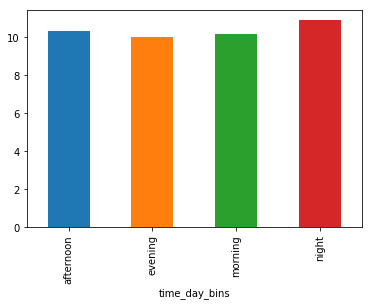

In [49]:
import matplotlib.pyplot as plt
clean_df.groupby('time_day_bins')['fare_amount'].mean().plot(kind='bar', x='time_day_bins', y='fare_amount')
plt.show()
plt.savefig('fare_vs_time_of_day.png')

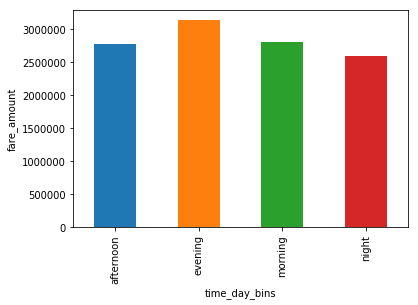

In [26]:
import matplotlib.pyplot as plt
plt.xlabel("time_day_bins")
plt.ylabel("fare_amount")
clean_df.groupby('time_day_bins')['fare_amount'].sum().plot(kind='bar', x='isWeekend', y='fare_amount')
plt.show()

In [29]:
# Additional Features
# 2. isWeekend
clean_df["isWeekend"] = clean_df.apply(lambda row: getWeekendWeekday(row["pickup_datetime"]), axis=1)
clean_df.tail()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,eucledian_dist,haversine_distance,time_day,time_day_cat,isWeekend
time_day_bins,,,,,,,,,,,,,,
morning,1021875,2014-09-06 09:13:00.0000002,5.5,2014-09-06 09:13:00 UTC,-74.0,40.8,-74.0,40.8,2,0.0,0.5,9,morning,1
evening,1021876,2014-01-07 19:45:44.0000006,10.5,2014-01-07 19:45:44 UTC,-74.0,40.8,-74.0,40.7,1,0.0,2.0,19,evening,0
morning,1021877,2012-09-13 09:56:00.00000053,13.0,2012-09-13 09:56:00 UTC,-74.0,40.7,-74.0,40.7,1,0.0,1.6,9,morning,0
morning,1021878,2010-12-13 08:41:08.0000006,5.7,2010-12-13 08:41:08 UTC,-74.0,40.8,-74.0,40.8,2,0.0,0.7,8,morning,0
evening,1021879,2013-08-10 18:03:17.0000001,12.0,2013-08-10 18:03:17 UTC,-74.0,40.8,-74.0,40.7,1,0.0,2.1,18,evening,1


In [30]:
# correlation between passenger count and Fair
clean_df["isWeekend"].corr(clean_df["fare_amount"])

-0.0024766951137848436

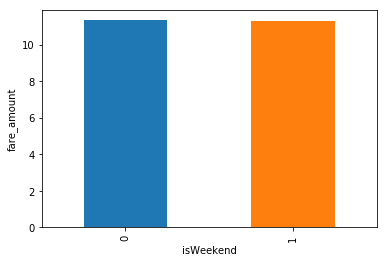

In [32]:
import matplotlib.pyplot as plt
plt.xlabel("isWeekend")
plt.ylabel("fare_amount")
clean_df.groupby('isWeekend')['fare_amount'].mean().plot(kind='bar', x='isWeekend', y='fare_amount')
#plt.scatter(clean_df["isWeekend"], clean_df["fare_amount"])
plt.show()

In [ ]:
The correlation between isWeekend feature and fare is very low.
The median fare on weekday and weekend is same.
The mean fare on weekday is slightly higher on weekdays.

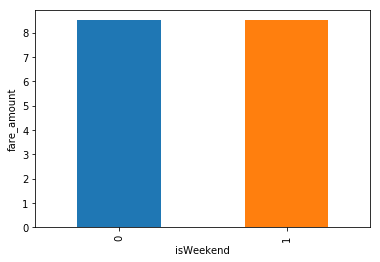

In [33]:
import matplotlib.pyplot as plt
plt.xlabel("isWeekend")
plt.ylabel("fare_amount")
clean_df.groupby('isWeekend')['fare_amount'].median().plot(kind='bar', x='isWeekend', y='fare_amount')
#plt.scatter(clean_df["isWeekend"], clean_df["fare_amount"])
plt.show()

In [51]:
#Additional Features 
# 3. Day_of_the_week
clean_df["day_of_the_week"] = clean_df.apply(lambda row: get_day_of_week(row["pickup_datetime"]), axis=1).astype(str)
clean_df.tail()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,eucledian_dist,...,time_of_day,time_bins,isEvening,isMorning,isAfterNoon,isNight,isHoliday,fuel_price,time_day_bins,day_of_the_week
9999995,10650895,2011-06-07 12:17:00.00000083,8.5,2011-06-07 12:17:00 UTC,-74.0,40.7,-74.0,40.7,1,0.0,...,44220,1,0,0,1,0,0,4.1,afternoon,2
9999996,10650896,2014-03-31 20:29:00.000000105,13.5,2014-03-31 20:29:00 UTC,-74.0,40.8,-74.0,40.7,1,0.0,...,73740,2,1,0,0,0,0,3.8,evening,1
9999997,10650897,2010-07-15 11:21:13.0000001,4.5,2010-07-15 11:21:13 UTC,-74.0,40.8,-74.0,40.8,1,0.0,...,40873,0,0,1,0,0,0,3.0,morning,4
9999998,10650899,2012-05-23 10:22:55.0000003,10.5,2012-05-23 10:22:55 UTC,-74.0,40.7,-74.0,40.8,1,0.0,...,37375,0,0,1,0,0,0,4.1,morning,3
9999999,10650900,2013-02-20 21:49:58.0000002,17.8,2013-02-20 21:49:58 UTC,-74.0,40.7,-74.0,40.7,1,0.0,...,78598,2,1,0,0,0,0,4.0,evening,3


In [56]:
clean_df.dtypes

Unnamed: 0              int64
key                    object
fare_amount           float64
pickup_datetime        object
pickup_longitude      float64
                       ...   
haversine_distance    float64
time_day                int64
time_day_cat           object
isWeekend               int64
day_of_the_week        object
Length: 15, dtype: object

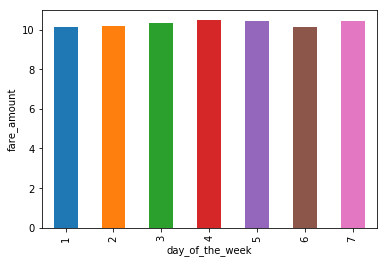

In [53]:
import matplotlib.pyplot as plt
plt.xlabel("day_of_the_week")
plt.ylabel("fare_amount")
clean_df.groupby('day_of_the_week')['fare_amount'].mean().plot(kind='bar', x=weekday_map.values(), y='fare_amount')
#plt.scatter(clean_df["isWeekend"], clean_df["fare_amount"])
plt.show()
plt.savefig('weekday_vs_fare_mean.png')

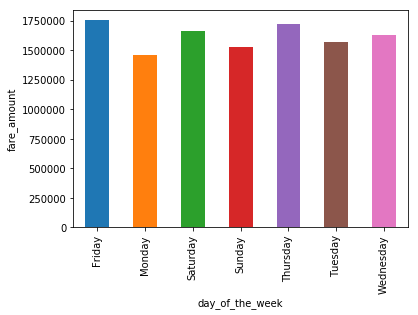

In [37]:
import matplotlib.pyplot as plt
plt.xlabel("day_of_the_week")
plt.ylabel("fare_amount")
clean_df.groupby('day_of_the_week')['fare_amount'].sum().plot(kind='bar', x='day_of_the_week', y='fare_amount')
#plt.scatter(clean_df["isWeekend"], clean_df["fare_amount"])
plt.show()

Q2) Correlations

2.1 Pearson Coefficient - Euclidean distance of the ride and the taxi fare.

In [8]:
clean_df["eucledian_dist"].corr(clean_df["fare_amount"])

0.8630464233158857

In [9]:
#Pearson Coefficient - Haversine distance of the ride and the taxi fare.
clean_df["haversine_distance"].corr(clean_df["fare_amount"])

0.8251712398896497

2.2 Pearson Coefficient - time of day and distance traveled. haversine is distance travelled

In [11]:
clean_df["time_day"].corr(clean_df["haversine_distance"])

-0.030356184646341808

2.3 Pearson Coefficient -time of day and the taxi fare

In [12]:
clean_df["time_day"].corr(clean_df["fare_amount"])

-0.019075226983687958

In [13]:
# correlation between passenger count and Fair
clean_df["passenger_count"].corr(clean_df["fare_amount"])

0.014696219572148889

In [14]:
# correlation between passenger count and Fair
clean_df["passenger_count"].corr(clean_df["haversine_distance"])

0.0112605049431714

In [39]:
clean_df.shape

(978569, 11)

Which has the highest correlation?
Ans = fare_amount vs eucledian_dist

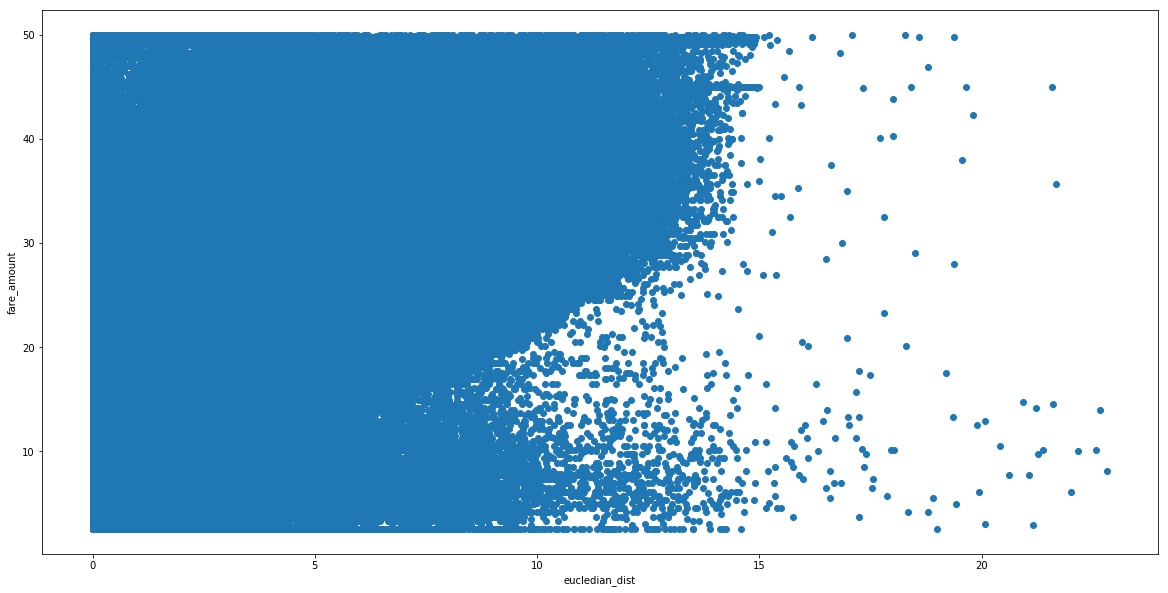

In [73]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.xlabel("eucledian_dist")
plt.ylabel("fare_amount")
plt.scatter(clean_df["haversine_distance"], clean_df["fare_amount"])
plt.show()
plt.savefig('fare_dist.png')

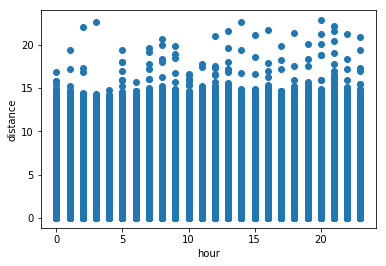

In [63]:
import matplotlib.pyplot as plt
plt.xlabel("hour")
plt.ylabel("distance")
plt.scatter(clean_df["hour"], clean_df["haversine_distance"])
plt.show()

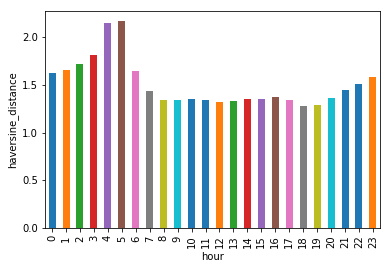

In [69]:
import matplotlib.pyplot as plt
plt.xlabel("hour")
plt.ylabel("haversine_distance")
clean_df.groupby('hour')['haversine_distance'].mean().plot(kind='bar', x='hour', y='fare_amount')
plt.show()
plt.savefig('time_of_day_vs_distance.png')

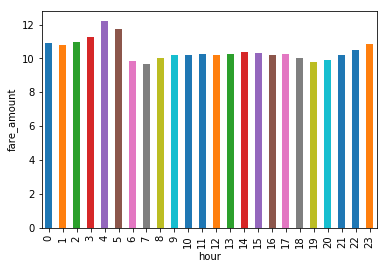

In [67]:
import matplotlib.pyplot as plt
plt.xlabel("hour")
plt.ylabel("fare_amount")
clean_df.groupby('hour')['fare_amount'].mean().plot(kind='bar', x='hour', y='fare_amount')
plt.show()

In [68]:
plt.savefig("time_of_day_vs_fare.png")

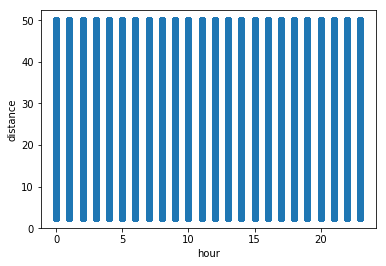

In [70]:
import matplotlib.pyplot as plt
plt.xlabel("hour")
plt.ylabel("distance")
plt.scatter(clean_df["hour"], clean_df["fare_amount"])
plt.show()

In [72]:
# Correlation between eucledian_dist and distance
clean_df["eucledian_dist"].corr(clean_df["haversine_distance"])

0.9138561431934867

In [ ]:
As expected its a very strong correlation.

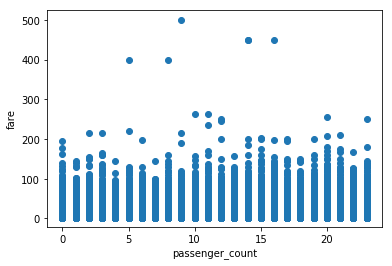

In [48]:
# Q4. Passenger count vs Fare
# Time of the day CDF in bins vs FARE
import matplotlib.pyplot as plt
plt.xlabel("passenger_count")
plt.ylabel("fare")
plt.scatter(clean_df["time_day"], clean_df["fare_amount"])
plt.show()

In [54]:
from datetime import datetime
def get_month(time_in_utc):
    time_obj = datetime.strptime(time_in_utc,'%Y-%m-%d %H:%M:%S UTC')
    return time_obj.month

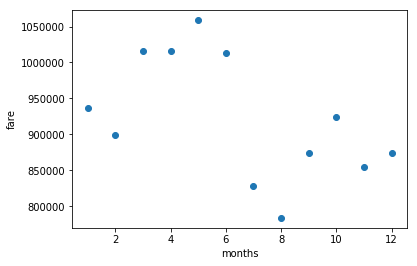

In [57]:
# Create a seasonal map of months vs Fare and
# months vs Dist Travelled - we expect holiday seasons like christmas and summer break to be busier.
season_dict = {}
for index, row in clean_df.iterrows():
    month = get_month(row["pickup_datetime"])
    if month not in season_dict:
        season_dict[month] = 0
    season_dict[month] += row["fare_amount"]

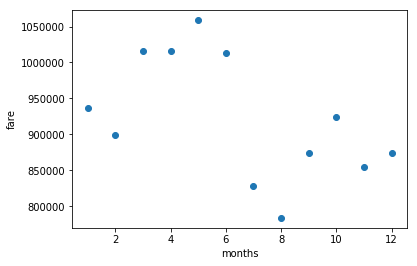

In [59]:
# Q4 Interesting plot seasonality
import matplotlib.pyplot as plt
plt.xlabel("months")
plt.ylabel("fare")
plt.scatter(kind = 'bar', season_dict.keys(),season_dict.values())
plt.show()

In [52]:
# Adding features to test_set
df_list = []
test_df = pd.read_csv('data/test.csv', chunksize=1000000)
for chunk in test_df:
    chunk["eucledian_dist"] = chunk.apply(lambda row: eucledian_dist(row["pickup_latitude"], row["pickup_longitude"], row["dropoff_latitude"], row["dropoff_longitude"]), axis=1)
    chunk["haversine_distance"] = chunk.apply(lambda row: haversine(row["pickup_latitude"], row["pickup_longitude"], row["dropoff_latitude"], row["dropoff_longitude"]), axis=1)
    chunk["hour"] = chunk.apply(lambda row: get_hour(row["pickup_datetime"]), axis=1)
    chunk["day_week"] = chunk.apply(lambda row: get_day_of_week(row["pickup_datetime"]), axis=1)
    chunk["year"] = chunk.apply(lambda row: get_year(row["pickup_datetime"]), axis=1)
    chunk["month"] = chunk.apply(lambda row: get_month(row["pickup_datetime"]), axis=1)
    chunk["time_of_day"] = chunk.apply(lambda row: get_time_of_the_day(row["pickup_datetime"]), axis=1)
    chunk["time_bins"] = chunk.apply(lambda row: get_timeday_bins(row["pickup_datetime"]), axis=1)
    chunk["isEvening"] = chunk.apply(lambda row: isEvening(row["pickup_datetime"]), axis=1)
    chunk["isMorning"] = chunk.apply(lambda row: isMorning(row["pickup_datetime"]), axis=1)
    chunk["isAfterNoon"] = chunk.apply(lambda row: isAfternoon(row["pickup_datetime"]), axis=1)
    chunk["isNight"] = chunk.apply(lambda row: isNight(row["pickup_datetime"]), axis=1)
    df_list.append(chunk)
test_df = pd.concat(df_list)
del df_list
test_df.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,eucledian_dist,haversine_distance,hour,day_week,year,month,time_of_day,time_bins,isEvening,isMorning,isAfterNoon,isNight
count,9914.0,9914.0,9914.0,9914.0,9914.0,9914.0,9914.0,9914.0,9914.0,9914.0,9914.0,9914.0,9914.0,9914.0,9914.0,9914.0,9914.0
mean,-74.0,40.8,-74.0,40.8,1.7,0.0,1.7,13.5,3.9,2011.8,6.9,50272.2,1.6,0.3,0.2,0.2,0.3
std,0.0,0.0,0.0,0.0,1.3,0.0,2.5,6.9,2.0,1.8,3.4,24678.4,1.1,0.4,0.4,0.4,0.4
min,-74.3,40.6,-74.3,40.6,1.0,0.0,0.0,0.0,1.0,2009.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0
25%,-74.0,40.7,-74.0,40.7,1.0,0.0,0.5,8.0,2.0,2010.0,4.0,30773.0,1.0,0.0,0.0,0.0,0.0
50%,-74.0,40.8,-74.0,40.8,1.0,0.0,1.0,15.0,4.0,2012.0,7.0,54146.0,2.0,0.0,0.0,0.0,0.0
75%,-74.0,40.8,-74.0,40.8,2.0,0.0,1.8,19.0,6.0,2014.0,10.0,71464.0,3.0,1.0,0.0,0.0,1.0
max,-73.0,41.7,-73.0,41.7,6.0,1.1,59.8,23.0,7.0,2015.0,12.0,86311.0,3.0,1.0,1.0,1.0,1.0


In [53]:
test_df.head(10)

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,eucledian_dist,haversine_distance,hour,day_week,year,month,time_of_day,time_bins,isEvening,isMorning,isAfterNoon,isNight
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-74.0,40.8,-74.0,40.7,1,0.0,0.7,13,2,2015,1,47304,1,0,0,1,0
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-74.0,40.7,-74.0,40.7,1,0.0,0.9,13,2,2015,1,47304,1,0,0,1,0
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-74.0,40.8,-74.0,40.7,1,0.0,0.2,11,6,2011,10,42824,0,0,1,0,0
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-74.0,40.8,-74.0,40.8,1,0.0,0.7,21,6,2012,12,76332,2,1,0,0,0
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-74.0,40.8,-74.0,40.7,1,0.1,1.8,21,6,2012,12,76332,2,1,0,0,0
5,2012-12-01 21:12:12.0000005,2012-12-01 21:12:12 UTC,-74.0,40.8,-74.0,40.7,1,0.0,1.3,21,6,2012,12,76332,2,1,0,0,0
6,2011-10-06 12:10:20.0000001,2011-10-06 12:10:20 UTC,-73.9,40.8,-74.0,40.8,1,0.0,0.7,12,4,2011,10,43820,1,0,0,1,0
7,2011-10-06 12:10:20.0000003,2011-10-06 12:10:20 UTC,-73.8,40.6,-74.0,40.8,1,0.2,14.5,12,4,2011,10,43820,1,0,0,1,0
8,2011-10-06 12:10:20.0000002,2011-10-06 12:10:20 UTC,-74.0,40.7,-74.0,40.7,1,0.0,1.4,12,4,2011,10,43820,1,0,0,1,0
9,2014-02-18 15:22:20.0000002,2014-02-18 15:22:20 UTC,-74.0,40.8,-74.0,40.8,1,0.0,0.8,15,2,2014,2,55340,1,0,0,1,0


In [55]:
test_df.to_csv('data/new_test.csv', mode='w', index=False)
# adding these new features to test data.

In [95]:
# Reading the test data
test_df = pd.read_csv('data/new_test.csv')
test_df.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,eucledian_dist,haversine_distance,hour,day_week,year,month,time_of_day,time_bins,isEvening,isMorning,isAfterNoon,isNight
count,9914.0,9914.0,9914.0,9914.0,9914.0,9914.0,9914.0,9914.0,9914.0,9914.0,9914.0,9914.0,9914.0,9914.0,9914.0,9914.0,9914.0
mean,-74.0,40.8,-74.0,40.8,1.7,0.0,1.7,13.5,3.9,2011.8,6.9,50272.2,1.6,0.3,0.2,0.2,0.3
std,0.0,0.0,0.0,0.0,1.3,0.0,2.5,6.9,2.0,1.8,3.4,24678.4,1.1,0.4,0.4,0.4,0.4
min,-74.3,40.6,-74.3,40.6,1.0,0.0,0.0,0.0,1.0,2009.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0
25%,-74.0,40.7,-74.0,40.7,1.0,0.0,0.5,8.0,2.0,2010.0,4.0,30773.0,1.0,0.0,0.0,0.0,0.0
50%,-74.0,40.8,-74.0,40.8,1.0,0.0,1.0,15.0,4.0,2012.0,7.0,54146.0,2.0,0.0,0.0,0.0,0.0
75%,-74.0,40.8,-74.0,40.8,2.0,0.0,1.8,19.0,6.0,2014.0,10.0,71464.0,3.0,1.0,0.0,0.0,1.0
max,-73.0,41.7,-73.0,41.7,6.0,1.1,59.8,23.0,7.0,2015.0,12.0,86311.0,3.0,1.0,1.0,1.0,1.0


In [6]:
test_df.isnull().sum()

key                   0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
passenger_count       0
eucledian_dist        0
haversine_distance    0
hour                  0
day_week              0
year                  0
month                 0
time_of_day           0
time_bins             0
isEvening             0
isMorning             0
isAfterNoon           0
isNight               0
dtype: int64

In [2]:
# reading training set with extra features
pd.options.display.float_format = '{:.1f}'.format
clean_df = pd.read_csv('data/Extra_features_10M.csv')
clean_df.describe()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,eucledian_dist,haversine_distance,hour,day_week,year,month,time_of_day,time_bins,isEvening,isMorning,isAfterNoon,isNight
count,10000000.0,10000000.0,10000000.0,10000000.0,10000000.0,10000000.0,10000000.0,10000000.0,10000000.0,10000000.0,10000000.0,10000000.0,10000000.0,10000000.0,10000000.0,10000000.0,10000000.0,10000000.0,10000000.0
mean,5325442.0,10.3,-74.0,40.8,-74.0,40.8,1.7,0.0,1.4,13.5,4.0,2011.7,6.3,50438.7,1.5,0.3,0.2,0.2,0.2
std,3074715.5,6.8,0.0,0.0,0.0,0.0,1.3,0.0,1.6,6.5,1.9,1.9,3.4,23524.9,1.1,0.5,0.4,0.4,0.4
min,0.0,2.5,-74.5,40.5,-74.5,40.5,1.0,0.0,0.0,0.0,1.0,2009.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,2662579.8,6.0,-74.0,40.7,-74.0,40.7,1.0,0.0,0.5,9.0,2.0,2010.0,3.0,33950.0,1.0,0.0,0.0,0.0,0.0
50%,5325594.5,8.1,-74.0,40.8,-74.0,40.8,1.0,0.0,1.0,14.0,4.0,2012.0,6.0,52774.0,2.0,0.0,0.0,0.0,0.0
75%,7988113.2,12.1,-74.0,40.8,-74.0,40.8,2.0,0.0,1.7,19.0,6.0,2013.0,9.0,70380.0,2.0,1.0,0.0,0.0,0.0
max,10650900.0,50.0,-73.8,41.0,-73.8,41.0,6.0,0.6,36.6,23.0,7.0,2015.0,12.0,86399.0,3.0,1.0,1.0,1.0,1.0


In [3]:
clean_df.isnull().sum()

Unnamed: 0            0
key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
passenger_count       0
eucledian_dist        0
haversine_distance    0
hour                  0
day_week              0
year                  0
month                 0
time_of_day           0
time_bins             0
isEvening             0
isMorning             0
isAfterNoon           0
isNight               0
dtype: int64

In [6]:
clean_df.dtypes

Unnamed: 0              int64
key                    object
fare_amount           float64
pickup_datetime        object
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
passenger_count         int64
eucledian_dist        float64
haversine_distance    float64
hour                    int64
day_week                int64
year                    int64
month                   int64
time_of_day             int64
time_bins               int64
isEvening               int64
isMorning               int64
isAfterNoon             int64
isNight                 int64
dtype: object

In [76]:
clean_df.head(50)

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,eucledian_dist,...,hour,day_week,year,month,time_of_day,time_bins,isEvening,isMorning,isAfterNoon,isNight
0,0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.8,40.7,-73.8,40.7,1,0.0,...,17,1,2009,6,62781,2,1,0,0,0
1,1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.0,40.7,-74.0,40.8,1,0.1,...,16,2,2010,1,60736,1,0,0,1,0
2,2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-74.0,40.8,-74.0,40.8,2,0.0,...,0,4,2011,8,2100,3,0,0,0,1
3,3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-74.0,40.7,-74.0,40.8,1,0.0,...,4,6,2012,4,16242,3,0,0,0,1
4,4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-74.0,40.8,-74.0,40.8,1,0.0,...,7,2,2010,3,28260,0,0,1,0,0
5,5,2011-01-06 09:50:45.0000002,12.1,2011-01-06 09:50:45 UTC,-74.0,40.7,-74.0,40.8,1,0.0,...,9,4,2011,1,35445,0,0,1,0,0
6,6,2012-11-20 20:35:00.0000001,7.5,2012-11-20 20:35:00 UTC,-74.0,40.8,-74.0,40.8,1,0.0,...,20,2,2012,11,74100,2,1,0,0,0
7,7,2012-01-04 17:22:00.00000081,16.5,2012-01-04 17:22:00 UTC,-74.0,40.8,-74.0,40.8,1,0.0,...,17,3,2012,1,62520,2,1,0,0,0
8,8,2012-12-03 13:10:00.000000125,9.0,2012-12-03 13:10:00 UTC,-74.0,40.7,-74.0,40.7,1,0.0,...,13,1,2012,12,47400,1,0,0,1,0
9,9,2009-09-02 01:11:00.00000083,8.9,2009-09-02 01:11:00 UTC,-74.0,40.7,-74.0,40.8,2,0.0,...,1,3,2009,9,4260,3,0,0,0,1


In [ ]:
# Baseline model 
# features - haversine distance, number of passengers, time of the day.
# Predict - Fare

In [77]:
clean_df.shape

(10000000, 21)

In [8]:
#Calculation correlations between 21 features and target
correlations = {}
clean_df['time_bins'].corr(clean_df['fare_amount'])

0.02892953110161254

In [9]:
clean_df['year'].corr(clean_df['fare_amount'])

0.1276527430639985

In [10]:
clean_df['month'].corr(clean_df['fare_amount'])

0.02714242086083711

In [12]:
clean_df['day_week'].corr(clean_df['fare_amount'])

0.008492538258590704

In [14]:
print(clean_df['isMorning'].corr(clean_df['fare_amount']))
print(clean_df['isAfterNoon'].corr(clean_df['fare_amount']))
print(clean_df['isEvening'].corr(clean_df['fare_amount']))
print(clean_df['isNight'].corr(clean_df['fare_amount']))

-0.014183329874342943
-0.0012402275210222108
-0.026940119554104434
0.0452075677683707


In [78]:
use_cols1 = ['eucledian_dist']    #4.79
use_cols0 = ['haversine_distance'] 
use_cols2 = ['haversine_distance', 'eucledian_dist', 'year', 'hour', 'month', 'day_week']

use_cols3 = ['haversine_distance', 'eucledian_dist', 'year', 'time_bins', 'month']

use_cols4 = ['haversine_distance','eucledian_dist', 'year', 'month', 'isMorning', 'day_week',
            'isAfterNoon', 'isEvening', 'isNight']

use_cols = use_cols2

from sklearn.model_selection import train_test_split
def splitData(use_cols):
    Y = clean_df['fare_amount']  
    X = clean_df[use_cols]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
    return X_train, Y_train, X_test, Y_test

In [79]:
from sklearn.linear_model import LinearRegression
def LR(use_cols):
    X_train, Y_train, X_test, Y_test =  splitData(use_cols)
    linear_model=LinearRegression()
    linear_model.fit(X_train,Y_train)
    linear_predictions = linear_model.predict(X_test)
    print(sqrt(mean_squared_error(Y_test, linear_predictions)))
    print(linear_model.score(X_test,Y_test))
    return linear_model, X_train, Y_train, X_test, Y_test, linear_predictions

3.3408740894429676
0.7583484857235608


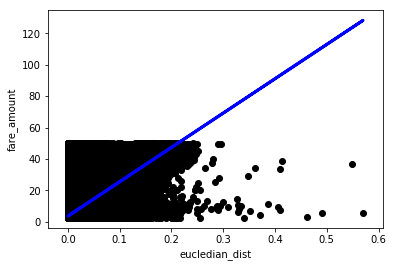

In [6]:
linear_model, X_train, Y_train, X_test, Y_test, linear_predictions = LR(use_cols1)
plt.scatter(X_test["eucledian_dist"], Y_test,  color='black')
plt.xlabel("eucledian_dist")
plt.ylabel("fare_amount")
plt.plot(X_test["eucledian_dist"], linear_predictions, color='blue', linewidth=3)

4.129918857485984
0.6308671167172621


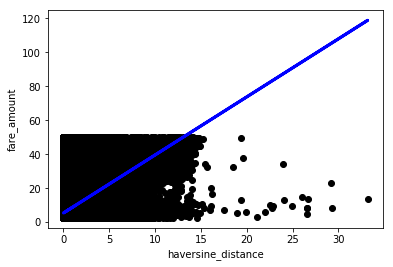

In [7]:
linear_model, X_train, Y_train, X_test, Y_test, linear_predictions = LR(use_cols0)
plt.scatter(X_test["haversine_distance"], Y_test,  color='black')
plt.xlabel("haversine_distance")
plt.ylabel("fare_amount")
plt.plot(X_test["haversine_distance"], linear_predictions, color='blue', linewidth=3)

From the graphs its clear that few outlier remain- 
Removing outliers- 

In [76]:
remove_df = clean_df[(clean_df["haversine_distance"]>30) | (clean_df["eucledian_dist"] > 0.35)]
remove_df.describe()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,eucledian_dist,haversine_distance,hour,...,year,month,time_of_day,time_bins,isEvening,isMorning,isAfterNoon,isNight,isHoliday,fuel_price
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
std,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
min,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
25%,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
50%,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
75%,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
max,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [9]:
tmp_df = clean_df.drop(remove_df.index)
print(len(tmp_df))

9999939


In [10]:
clean_df = tmp_df
print(len(clean_df))

9999939


In [81]:
linear_model, X_train, Y_train, X_test, Y_test, linear_predictions = LR(use_cols4)

3.183077772585953
0.7798614335726899


In [12]:
# The coefficients
print('Coefficients: \n', linear_model.coef_)

Coefficients: 
 [-7.68256469e-02  2.23968911e+02  4.59323457e-01  6.61567685e-02
 -6.13875632e+10 -6.13875632e+10 -6.13875632e+10 -6.13875632e+10]


#Plot of linear Regression

In [80]:
from sklearn import linear_model
X_train, Y_train, X_test, Y_test = splitData(use_cols4)
ridge_model = linear_model.Ridge(alpha=1.0)
ridge_model.fit(X_train, Y_train)
ridge_predictions = ridge_model.predict(X_test)
print(sqrt(mean_squared_error(Y_test, ridge_predictions)))
print(ridge_model.score(X_test, Y_test))

3.2061819144767636
0.7770308373691424


In [14]:
from sklearn import linear_model
X_train, Y_train, X_test, Y_test = splitData(use_cols4)
lasso_model = linear_model.Lasso(alpha=1.0)
lasso_model.fit(X_train, Y_train)
lasso_predictions = lasso_model.predict(X_test)
print(sqrt(mean_squared_error(Y_test, lasso_predictions)))
print(lasso_model.score(X_test, Y_test))

4.125952962340407
0.6322063069609292


In [112]:
#Testing linear model on test data -
X_test_kg = test_df[extra_cols]
linear_predictions = linear_model.predict(X_test_kg)

In [113]:
submission = pd.read_csv('data/sample_submission.csv')
submission['fare_amount'] = linear_predictions
submission.to_csv('submission_linear.csv', index=False)

Additional Dataset that improved performance and added a feature - 
https://www.kaggle.com/gsnehaa21/federal-holidays-usa-19662020#usholidays.csv
Federal Holidays USA 1966-2020
US federal holidays 1966-2020

https://data.ny.gov/Energy-Environment/Gasoline-Retail-Prices-Weekly-Average-by-Region-Be/nqur-w4p7
Gasoline Retail Prices Weekly Average by Region: Beginning 2007Energy & Environment


In [15]:
def get_holiday_set():
    holidays_df = pd.read_csv('data/usholidays.csv')
    dates_df = holidays_df['Date']
    dates_df.describe()
    holiday_set = set()
    for value in dates_df:
        holiday_set.add(value)
    return holiday_set

In [16]:
fuel_prices = pd.read_csv('data/Gasoline_Retail_Prices_Weekly_Average_by_Region__Beginning_2007.csv')
fuel_prices.head(4)
fuel_df  = fuel_prices [["Date", "NewYorkCityAverage($/gal)"]]
fuel_df.head(4)

,Date,NewYorkCityAverage($/gal)
0,8/27/18,3.1
1,8/20/18,3.1
2,8/13/18,3.1
3,8/6/18,3.1


In [17]:
fuel_dict = {}
for index, row in fuel_df.iterrows():
    dt = str(datetime.strptime(row["Date"],'%m/%d/%y').date())
    fuel_dict[dt] = row["NewYorkCityAverage($/gal)"]
print(fuel_dict)

{'2018-08-27': 3.1, '2018-08-20': 3.11, '2018-08-13': 3.1, '2018-08-06': 3.1, '2018-07-30': 3.1, '2018-07-23': 3.1, '2018-07-16': 3.11, '2018-07-09': 3.12, '2018-07-02': 3.11, '2018-06-25': 3.13, '2018-06-18': 3.16, '2018-06-11': 3.19, '2018-06-04': 3.21, '2018-05-28': 3.2, '2018-05-21': 3.14, '2018-05-14': 3.08, '2018-05-07': 3.05, '2018-04-30': 3.02, '2018-04-23': 2.94, '2018-04-16': 2.88, '2018-04-09': 2.86, '2018-04-02': 2.85, '2018-03-26': 2.79, '2018-03-19': 2.76, '2018-03-12': 2.77, '2018-03-05': 2.79, '2018-02-26': 2.8, '2018-02-19': 2.82, '2018-02-12': 2.85, '2018-02-05': 2.85, '2018-01-29': 2.81, '2018-01-22': 2.78, '2018-01-15': 2.75, '2018-01-08': 2.74, '2018-01-01': 2.72, '2017-12-25': 2.72, '2017-12-18': 2.73, '2017-12-11': 2.75, '2017-12-04': 2.77, '2017-11-27': 2.78, '2017-11-20': 2.79, '2017-11-13': 2.8, '2017-11-06': 2.77, '2017-10-30': 2.77, '2017-10-23': 2.78, '2017-10-16': 2.81, '2017-10-09': 2.85, '2017-10-02': 2.88, '2017-09-25': 2.93, '2017-09-18': 2.96, '2017-0

In [18]:
def getLastMonday(time_in_utc):
    dt = datetime.strptime(time_in_utc,'%Y-%m-%d %H:%M:%S UTC').date()
    cnt = dt.weekday()
    dt = dt - timedelta(days=cnt)
    return str(dt)

In [19]:
def getFuelPrice(time_in_utc):
    dt = getLastMonday(time_in_utc)
    if dt in fuel_dict:
        return fuel_dict[dt]

In [20]:
getFuelPrice('2010-01-05 16:52:16 UTC')

2.88

In [21]:
def get_isHoliday(time_in_utc, holiday_set):
    dt = str(datetime.strptime(time_in_utc,'%Y-%m-%d %H:%M:%S UTC').date())
    if dt in holiday_set:
        return 1
    return 0

In [22]:
holiday_set = get_holiday_set()
clean_df["isHoliday"] = clean_df.apply(lambda row: get_isHoliday(row["pickup_datetime"], holiday_set), axis=1)

In [24]:
clean_df["fuel_price"] = clean_df.apply(lambda row: getFuelPrice(row["pickup_datetime"]), axis=1)

In [96]:
test_df["isHoliday"] = test_df.apply(lambda row: get_isHoliday(row["pickup_datetime"], holiday_set), axis=1)

In [97]:
test_df["fuel_price"] = test_df.apply(lambda row: getFuelPrice(row["pickup_datetime"]), axis=1)

In [23]:
clean_df["isHoliday"].corr(clean_df["fare_amount"])

-0.0034217220893238494

In [25]:
clean_df["fuel_price"].corr(clean_df["fare_amount"])

0.05474976692066052

In [26]:
clean_df.describe()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,eucledian_dist,haversine_distance,hour,...,year,month,time_of_day,time_bins,isEvening,isMorning,isAfterNoon,isNight,isHoliday,fuel_price
count,9999939.0,9999939.0,9999939.0,9999939.0,9999939.0,9999939.0,9999939.0,9999939.0,9999939.0,9999939.0,...,9999939.0,9999939.0,9999939.0,9999939.0,9999939.0,9999939.0,9999939.0,9999939.0,9999939.0,9999939.0
mean,5325444.8,10.3,-74.0,40.8,-74.0,40.8,1.7,0.0,1.4,13.5,...,2011.7,6.3,50438.8,1.5,0.3,0.2,0.2,0.2,0.0,3.5
std,3074716.9,6.8,0.0,0.0,0.0,0.0,1.3,0.0,1.6,6.5,...,1.9,3.4,23524.9,1.1,0.5,0.4,0.4,0.4,0.1,0.6
min,0.0,2.5,-74.5,40.5,-74.5,40.5,1.0,0.0,0.0,0.0,...,2009.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.9
25%,2662582.5,6.0,-74.0,40.7,-74.0,40.7,1.0,0.0,0.5,9.0,...,2010.0,3.0,33950.0,1.0,0.0,0.0,0.0,0.0,0.0,2.9
50%,5325598.0,8.1,-74.0,40.8,-74.0,40.8,1.0,0.0,1.0,14.0,...,2012.0,6.0,52774.0,2.0,0.0,0.0,0.0,0.0,0.0,3.7
75%,7988120.5,12.1,-74.0,40.8,-74.0,40.8,2.0,0.0,1.7,19.0,...,2013.0,9.0,70380.0,2.0,1.0,0.0,0.0,0.0,0.0,4.0
max,10650900.0,50.0,-73.8,41.0,-73.8,41.0,6.0,0.3,22.8,23.0,...,2015.0,12.0,86399.0,3.0,1.0,1.0,1.0,1.0,1.0,4.3


Using extra features on models

In [84]:
extra_cols = ['haversine_distance', 'eucledian_dist', 'year', 'hour', 'month', 'day_week', 'fuel_price']

In [90]:
extra_cols2 = ['haversine_distance','eucledian_dist', 'year', 'month', 'fuel_price', 'isMorning', 'day_week',
            'isAfterNoon', 'isEvening', 'isNight']

In [111]:
linear_model, X_train, Y_train, X_test, Y_test, linear_predictions = LR(extra_cols)

3.2113318883166717
0.7763734835183669


In [91]:
linear_model, X_train, Y_train, X_test, Y_test, linear_predictions = LR(extra_cols2)

3.202605794168817
0.7785187111701168


In [36]:
# Random Forest
rf_model = RandomForestRegressor()
X_train, Y_train, X_test, Y_test = splitData(use_cols4)
print(X_train.shape)
print(Y_train.shape)
rf_model.fit(X_train, Y_train)
randomForest_predictions = rf_model.predict(X_test)
print(rf_model.score(X_test, Y_test))
print(sqrt(mean_squared_error(Y_test, randomForest_predictions)))

(7999951, 8)
(7999951,)
0.7908333830129557
3.1093818338985977


In [103]:
# Random Forest using external dataset features
rf_model = RandomForestRegressor()
X_train, Y_train, X_test, Y_test = splitData(extra_cols)
print(X_train.shape)
print(Y_train.shape)
rf_model.fit(X_train, Y_train)
randomForest_predictions = rf_model.predict(X_test)
print(rf_model.score(X_test, Y_test))
print(sqrt(mean_squared_error(Y_test, randomForest_predictions)))

(7999951, 7)
(7999951,)
0.80571551568769
2.993895547894496


In [104]:
#Testing Random Forest model on test data -
X_test_kg = test_df[extra_cols]
randomForest_predictions = rf_model.predict(X_test_kg)

In [105]:
submission = pd.read_csv('data/sample_submission.csv')
submission['fare_amount'] = randomForest_predictions
submission.to_csv('submission_rf.csv', index=False)

In [106]:
#xgboost
X_train, Y_train, X_test, Y_test = splitData(use_cols4)
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
xgb_model = xgb.fit(X_train,Y_train)
xgb_predictions = xgb.predict(X_test)

[02:40:20] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'


In [108]:
#xgboost
X_train, Y_train, X_test, Y_test = splitData(extra_cols)
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
xgb_model = xgb.fit(X_train,Y_train)
xgb_predictions = xgb.predict(X_test)

[03:04:13] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'


In [107]:
print(sqrt(mean_squared_error(Y_test, xgb_predictions)))
print(explained_variance_score(xgb_predictions,Y_test))

2.8348102023632062
0.7876519314721763


In [109]:
#Testing xgboost model on test data -
X_test_kg = test_df[extra_cols]
xgb_predictions = xgb_model.predict(X_test_kg)

In [110]:
submission = pd.read_csv('data/sample_submission.csv')
submission['fare_amount'] = xgb_predictions
submission.to_csv('submission_xgb.csv', index=False)